# Introduction to RayleighSolverApp

`RayleighSolverApp` is a basic application that simulates a one dimensional scene with an atmosphere that exhibits only rayleigh scattering. While of limited use in research it serves as a simple way to introduce Eradiate and its features.

This tutorial is available as a ipython notebook in the Eradiate codebase in `resources/data/demo_spr1/3-rayleigh_solver_app/rayleigh_solver_app.ipynb`

## Instantiation and configuration

We start by importing RayleighSolverApp:

In [1]:
from eradiate.solvers.onedim.rayleigh import RayleighSolverApp

All Eradiate applications are configured with dictionaries. The following dictionary configures `RayleighSolverApp` for a monochromatic simulation with a surface that exhibits lamberian scattering.

In [2]:
config = {
    'mode': {
        'type': 'mono',
        'wavelength': 577.  # nm
    },
    'illumination': {
        'type': 'directional',
        'zenith': 30.,  # deg
        'azimuth': 0.,  # deg
        'irradiance': {
           "type": "uniform",
           "value": 1.8e+6  # W/km^2/nm
       }
    },
    'surface': {
        'type': 'lambertian',
        'reflectance': {
            "type": "uniform",
           "value": 0.5
        }
    },
    'atmosphere': {
        'type': 'rayleigh_homogeneous',
        'height': 40.,  # km
    },
    'measure': [{
        'type': 'hemispherical',
        'spp': 32000,  # dimensionless
        'zenith_res': 10.,  # deg
        'azimuth_res': 10.  # deg
    }]
}
app = RayleighSolverApp(config)

Here is a brief explanation of the five major sections of this configuration dictionary:

- `mode`

  The `mode` section sets internal details of Eradiate's computational kernel. `RayleighSolverApp` only supports one mode, called `mono`. In this mode a monochromatic simulation is performed, which means that only one 
  wavelength is transported per ray. Additionally the `mono` mode sets the wavelength for the simulation which is used to compute the scattering parameters of the atmosphere
- `illumination`

  The `illumination` section defines the light source in the simulation. Here a `directional` light source is used, which implements light from an infinitely distant emitter, which emits light into one single direction.
  This plugin's parameters set the emitter's direction through its zenith and azimuth angle (also known as `sun zenith angle` and `sun azimuth angle`) and its irradiance given in units of `Watts per square kilometer per nanometer`.
- `surface`

  The `surface` section sets the surface's BRDF. `RayleighSolverApp` supports two kinds of BRDF for its surface: `lambertian` and `RPV`. Here a `lambertian` surface is set, with a reflectance of 0.5.
- `atmosphere`

  The `atmosphere` section sets all necessary parameters for the rayleigh scattering. Here only the total height of the atmosphere can be set. Note that this is a homogeneous atmosphere, which means the atmospheric properties are the same everywhere.

- `measure`

  The `measure` section defines the observational parameters. Here a hemispherical measure is chosen, which means that the exiting radiance into the entire hemisphere will be recorded. The `spp` parameter defines the number
  of samples drawn per observational direction and `zenith_res` and `azimuth_res` define the angular resolution in zenith and azimuth direction in degrees respectively.
  
Finally, the `RayleighSolverApp` is instantiated by passing the config to its constructor.

## Configure using a YAML file

Alternatively a YAML file may be used to configure `RayleighSolverApp`. The yaml file effectively implements the dictionary we created above. Opening the file and loading its contents into a Python object are straightforward.

In [3]:
import yaml

with open("config.yml", 'r') as f:
    yaml_config = yaml.safe_load(f)
    app = RayleighSolverApp(yaml_config)

## Running the simulation

To make the application execute the simulation, simply write:

In [4]:
app.run()

The application collects the raw results that you can retrieve and postprocess at your convenience. These raw results are stored into a labeled multidimensional array (`DataArray` from the [xarray](http://xarray.pydata.org) library) that allows for easy postprocessing, including exporting the results data to the netCDF format.

In [5]:
display(app.results[0])

<xarray.Dataset>
Dimensions:           (saa: 1, sza: 1, vaa: 36, vza: 9, wavelength: 1)
Coordinates:
  * sza               (sza) float64 30.0
  * saa               (saa) float64 0.0
  * vza               (vza) float64 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0
  * vaa               (vaa) float64 0.0 10.0 20.0 30.0 ... 330.0 340.0 350.0
  * wavelength        (wavelength) float64 577.0
Data variables:
    toa_lo_hsphere    (sza, saa, vza, vaa, wavelength) float64 2.627e+05 ... ...
    irradiance        (sza, saa, wavelength) float64 1.8e+06
    toa_brdf_hsphere  (sza, saa, vza, vaa, wavelength) float64 0.146 ... 0.1652
    toa_brf_hsphere   (sza, saa, vza, vaa, wavelength) float64 0.04646 ... 0....
Attributes:
    angle_convention:  eo_scene
    angular_domain:    hsphere

## Visualising the results

Additionally, ``RayleighSolverApp`` lets you visualize the results by producing specialised plots with the collected results.

We use the `squeeze()` method of the xarray data to remove dimensions with only one entry. Afterwards we use the `ert.plot()` method of our data storage to create a polar plot with a `matplotlib.pyplot.pcolormesh` visual style.

The remaining code sets the axis label for the plotted data and displays the plot.

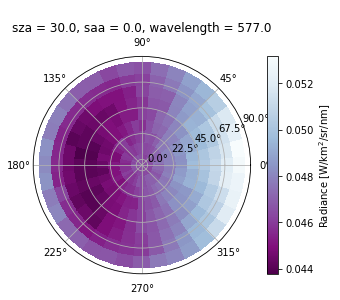

In [6]:
lo = app.results[0].toa_brf_hsphere.squeeze()
lo.ert.plot(kind="polar_pcolormesh")

# Hacky but only way to tune color bar without modifying the code
import matplotlib.pyplot as plt

plt.gcf().axes[1].set_ylabel("Radiance [W/km$^2$/sr/nm]")
plt.show()
plt.close()

As an alternative we can produce a plot of the principal plane. First we import the principal plane class from the Eradiate data viewer utility (`eradiate.util.view`), then we cast our data into the pplane structure, by passing the results to the `pplane()` constructor. Finally we call the data structure's `plot()` method and set the axes' labels to complete the visualization.

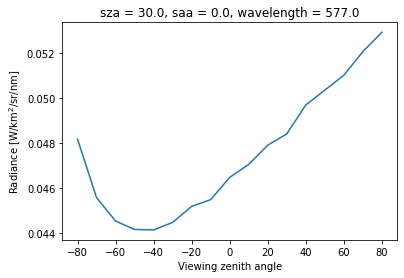

In [7]:
from eradiate.util.view import pplane

pplane_data = pplane(app.results[0]["toa_brf_hsphere"])
#display(pplane_data)

pplane_data.plot()

# Hacky but only way to tune axes without modifying the code
import matplotlib.pyplot as plt

plt.gca().set_xlabel("Viewing zenith angle")
plt.gca().set_ylabel("Radiance [W/km$^2$/sr/nm]")
plt.show()
plt.close()